In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import nd2
import numpy as np
import os
import numpy as np
import cv2
import pandas as pd

In [4]:
path = '..\data\iScat\Data\\2024_11_11\\Metasurface\\Chip_02\\Metasurface 01\\Brightfield'
z_stack_path = path+'\\02_01_BF.nd2'
f1_path = path+'\\Captured Cy5.tif'
f2_path = path+'\\Captured FITC.tif'
f3_path = path+'\\Captured TRITC.tif'
f1_results = path+"\\Cy5.csv"
f2_results = path+"\\FITC.csv"
f3_results = path+"\\TRITC.csv"
z_stack_image = nd2.imread(z_stack_path)
f1_img =  Image.open(f1_path)
f2_img =  Image.open(f2_path)
f3_img =  Image.open(f3_path)

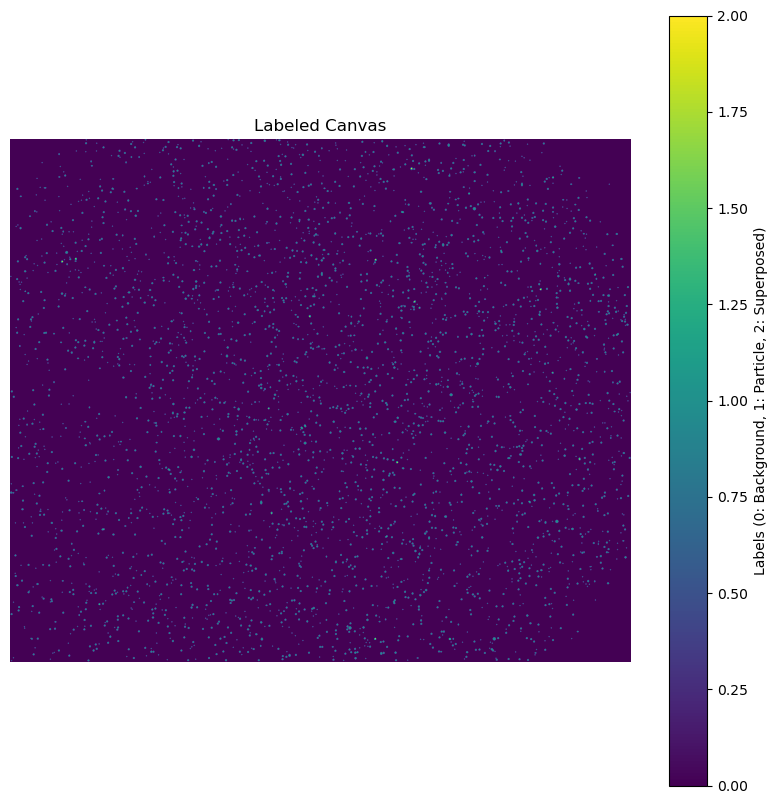

In [8]:
def label_particles(image_shape, csv_files):
    """
    Labels a canvas based on particle data from CSV files.
    
    Args:
        image_shape (tuple): Shape of the fluorescence image (height, width).
        csv_files (list of str): Paths to CSV files with particle positions.
    
    Returns:
        np.ndarray: Labeled canvas with classes:
                    0 - Background
                    1 - Particle
                    2 - Superposed Particle
    """
    # Initialize the canvas
    label_canvas = np.zeros(image_shape, dtype=np.uint8)
    
    for csv_file in csv_files:
        # Load particle data
        particle_data = pd.read_csv(csv_file)
        
        for _, row in particle_data.iterrows():
            # Extract bounding rectangle and compute ellipse center
            x_min, y_min = row['xMin'], row['yMin']
            x_max, y_max = row['xMax'], row['yMax']
            center_x = int((x_min + x_max) / 2)
            center_y = int((y_min + y_max) / 2)
            
            # Compute ellipse axes
            axes_x = int((x_max - x_min) / 2)
            axes_y = int((y_max - y_min) / 2)
            
            # Draw the ellipse on a temporary canvas
            temp_canvas = np.zeros_like(label_canvas)
            cv2.ellipse(
                temp_canvas,
                (center_x, center_y),
                (axes_x, axes_y),
                0, 0, 360, 1, -1
            )
            
            # Identify overlapping regions
            overlap = (label_canvas == 1) & (temp_canvas == 1)
            label_canvas[overlap] = 2
            
            # Add non-overlapping regions
            label_canvas[(label_canvas == 0) & (temp_canvas == 1)] = 1
    
    return label_canvas


def visualize_labeled_canvas(z_stack_image, csv_files):
    """
    Labels particles on a canvas and visualizes the result.

    Args:
        z_stack_image (np.ndarray): The fluorescence image stack.
        csv_files (list of str): Paths to CSV files with particle positions.
    
    Returns:
        np.ndarray: Labeled canvas with classes:
                    0 - Background
                    1 - Particle
                    2 - Superposed Particle
    """
    # Get the shape of the canvas
    image_shape = z_stack_image.shape[1:]
    
    # Generate the labeled canvas
    labeled_canvas = label_particles(image_shape, csv_files)
    
    # Plot the labeled canvas
    plt.figure(figsize=(10, 10))
    plt.title("Labeled Canvas")
    plt.imshow(labeled_canvas, cmap='viridis')
    plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
    plt.axis('off')
    plt.show()
    
    return labeled_canvas

# Simulating a fluorescence image stack (dummy data for visualization)

csv_files = [f1_results, f2_results, f3_results]
labeled_canvas_visual = visualize_labeled_canvas(z_stack_image, csv_files)

In [19]:
u,c=np.unique(labeled_canvas_visual, return_counts=True)
print(c)

[5417493  111533     574]


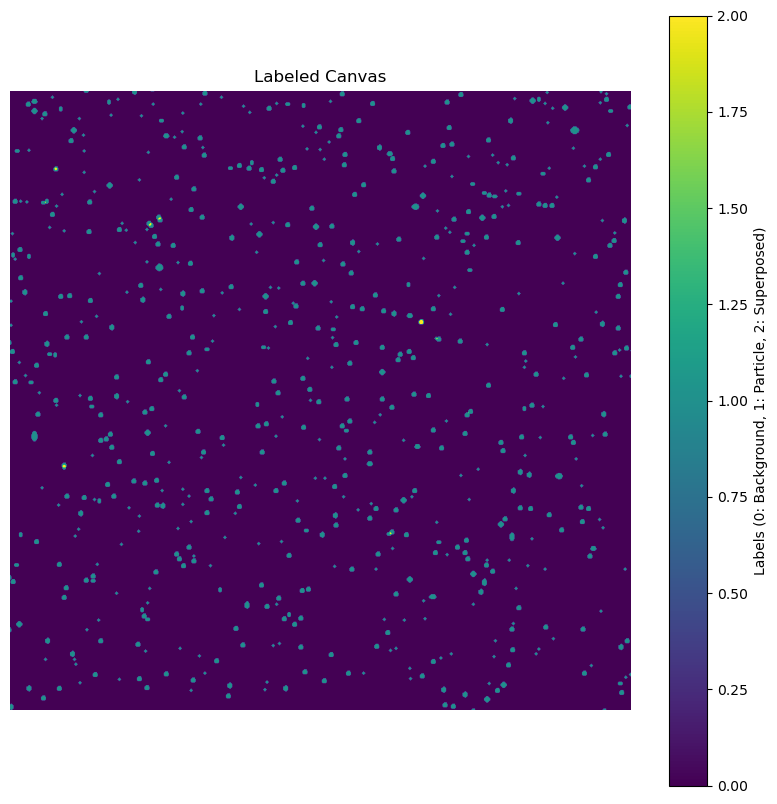

In [15]:
plt.figure(figsize=(10, 10))
plt.title("Labeled Canvas")
plt.imshow(labeled_canvas_visual[1000:1900,1000:1900] , cmap='viridis')
plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
plt.axis('off')
plt.show()

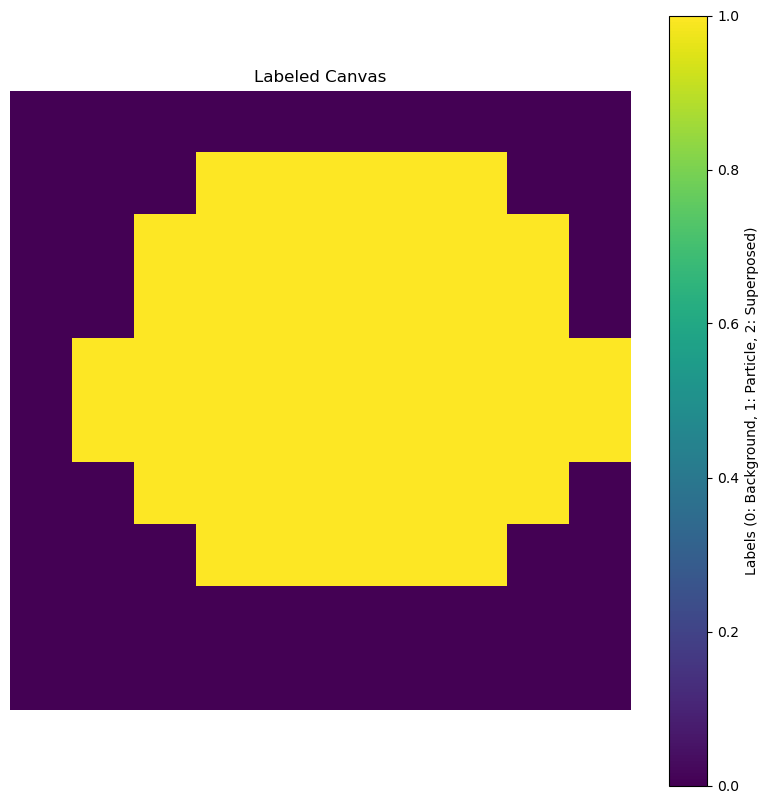

In [11]:
plt.figure(figsize=(10, 10))
plt.title("Labeled Canvas")
plt.imshow(labeled_canvas_visual[580:590,510:520] , cmap='viridis')
plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
plt.axis('off')
plt.show()

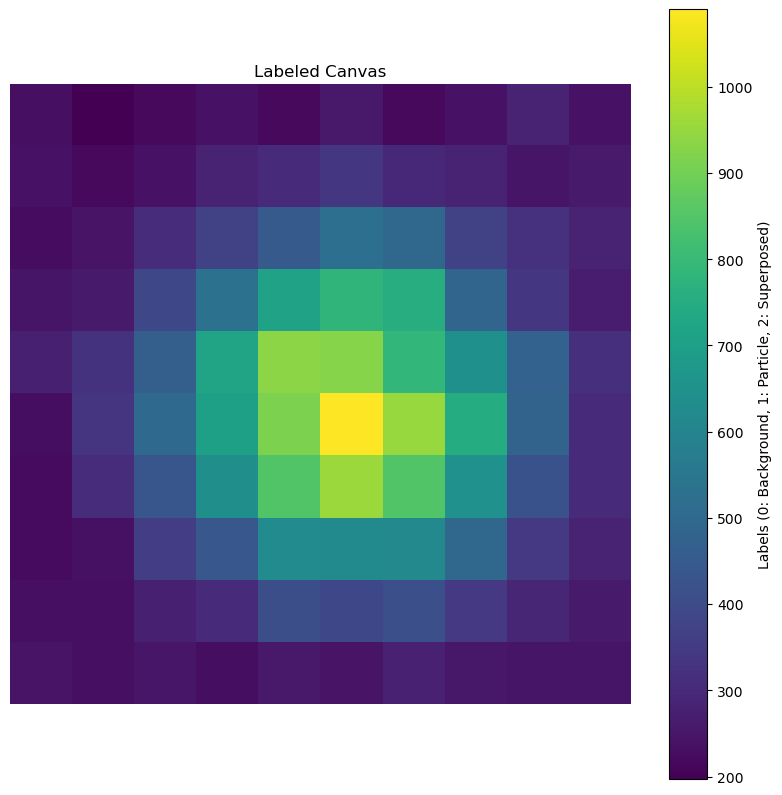

In [10]:
image = plt.imread(f1_path)
plt.figure(figsize=(10, 10))
plt.title("Labeled Canvas")
plt.imshow(image[580:590,510:520] , cmap='viridis')
plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
plt.axis('off')
plt.show()